# Exercise 07.1

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, log, exp
import math
import scipy
from scipy import constants
import subprocess

sourceDirectory = 'MonteCarlo_NVT/'
sourceDirectoryNVE = 'MolecularDynamics_NVE/'

phases = ['Solid', 'Liquid', 'Gas']

T_solid = "0.8"
T_liquid = "1.1"
T_gas = "1.2"

rho_solid = "1.1"
rho_liquid = "0.8"
rho_gas = "0.05"

rc_solid = "2.2"
rc_liquid = "2.5"
rc_gas = "5.0"

titleSize = 20
axesLabelSize = 15

In [3]:
def source_dir(NVT_NVE):
    if NVT_NVE == 'NVT':
        return sourceDirectory
    else:
        return sourceDirectoryNVE
    
def delta(phase):
    if phase == 'Solid':
        return 0.1
    elif phase == 'Liquid':
        return 0.2
    else:
        return 5.0

def reset_simulation(NVT_NVE):
    source_directory = source_dir(NVT_NVE)
    if NVT_NVE == 'NVT':
        subprocess.check_output(["/bin/sh", "-c", "cd "+source_directory+"; ./clean.sh; make clean"])
    else:
        subprocess.check_output(["/bin/sh", "-c", "cd "+source_directory+"; make clean"])
        subprocess.check_output(["/bin/sh", "-c", "rm -rf "+source_directory+"old.0"])
        subprocess.check_output(["/bin/sh", "-c", "cp "+source_directory+"config.0_bak "+sourceDirectory+"config.0"])
        
def compile_simulation(NVT_NVE):
    source_directory = source_dir(NVT_NVE)
    subprocess.check_output(["/bin/sh", "-c", "cd "+source_directory+"; make"])
    
def run_simulation(NVT_NVE):
    source_directory = source_dir(NVT_NVE)
    if NVT_NVE == 'NVT':
        subprocess.check_output(["/bin/sh", "-c", "cd "+source_directory+"; ./Monte_Carlo_NVT.exe"])
    else:
        subprocess.check_output(["/bin/sh", "-c", "cd "+source_directory+"; ./MolDyn_NVE.exe"])

def restart_simulation(NVT_NVE):
    source_directory = source_dir(NVT_NVE)
    if NVT_NVE == 'NVE':
        subprocess.check_output(["/bin/sh", "-c", "mv "+source_directory+"config.final "+source_directory+"config.0"])
        subprocess.check_output(["/bin/sh", "-c", "mv "+source_directory+"old.final "+source_directory+"old.0"])
        run_simulation(NVT_NVE)

def clean_output_files(NVT_NVE):
    source_directory = source_dir(NVT_NVE)
    if NVT_NVE == 'NVE':
        subprocess.check_output(["/bin/sh", "-c", "rm -rf "+source_directory+"output_*.dat"])
    
def initial_parameters(phase):
    if phase == 'Solid':
        return T_solid, rho_solid, rc_solid
    elif phase == 'Liquid':
        return T_liquid, rho_liquid, rc_liquid
    else:
        return T_gas, rho_gas, rc_gas

def set_input_file(phase, NVT_NVE, nblk, nstep, equilibriumSteps):
    a, b, c = initial_parameters(phase)
    source_directory = source_dir(NVT_NVE)
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(a)+'/ if $. == 1" '+source_directory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(b)+'/ if $. == 3" '+source_directory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(c)+'/ if $. == 4" '+source_directory+"input.dat"])
    if NVT_NVE == 'NVT':
        subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(delta(phase))+'/ if $. == 5" '+source_directory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(nblk)+'/ if $. == 6" '+source_directory+"input.dat"])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(nstep)+'/ if $. == 7" '+source_directory+"input.dat"])
    if NVT_NVE == 'NVT':
        subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/^.*.$/'+str(equilibriumSteps)+'/ if $. == 8" '+source_directory+"input.dat"])

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2 - AV**2)/n)

Use the Monte Carlo NVT code we have provided to print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along equilibrated Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
 - solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
 - liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
 - gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

First of all, I try to set the acceptance ratio approximately to 50%. In order to get it, I change the value of ```delta```.  
These are the values for each phase:
 - Solid: 0.1
 - Liquid: 0.2
 - Gas: 5.0  
Then I run the simulation for all three phases (solid, liquid and gas) e I show in a picture (using Lennard-Jones units) the potential energy as a function of the number of steps. I thus try to understand at what point the system reaches equilibrium.

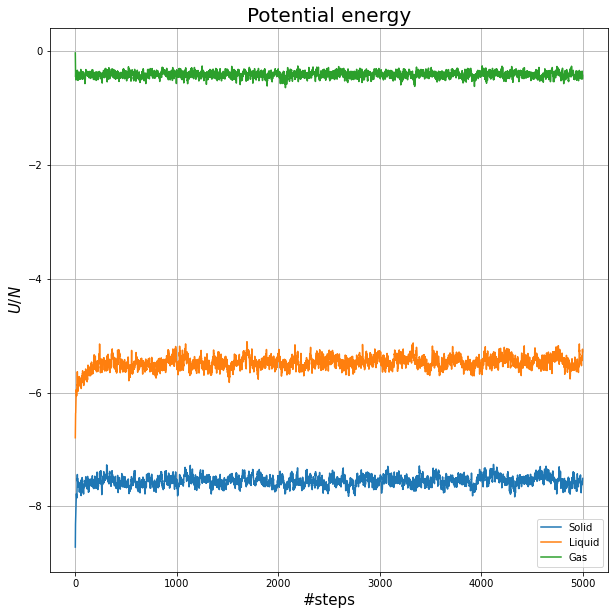

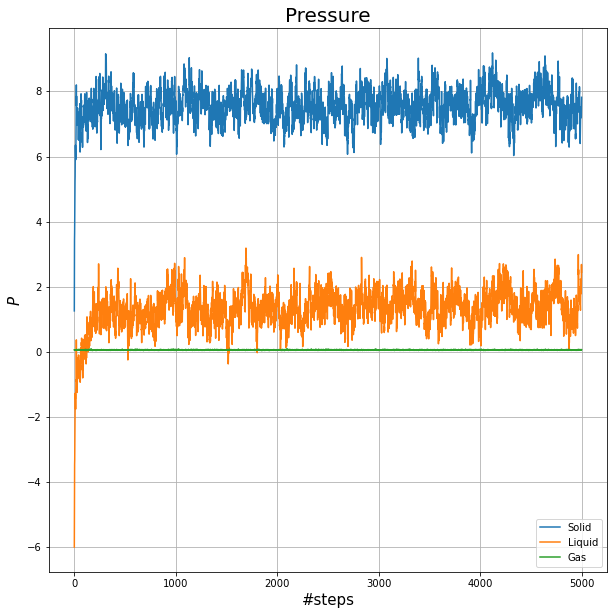

In [3]:
nBlocks = 5000
stepsPerBlock = 1

restart = False
source_directory = source_dir('NVT')

if restart:
    for phase in phases:
        set_input_file(phase, 'NVT', nBlocks, stepsPerBlock, 0)
        reset_simulation('NVT')
        compile_simulation('NVT')
        run_simulation('NVT')
    
        subprocess.check_output(["/bin/sh", "-c", "cp "+source_directory+"output.epot.i.0 01/"+str(phase)+'/output.epot.i.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+source_directory+"output.pres.i.0 01/"+str(phase)+'/output.pres.i.0'])

x = np.arange(nBlocks*stepsPerBlock+1)
plt.figure(figsize=(10, 10))
plt.title('Potential energy', fontsize=titleSize)
counter = 0
for phase in phases:    
    epot = []
    i = 0
    with open("01/"+str(phase)+'/output.epot.i.0', 'r') as reader:
        for line in reader:
            epot.append(float(line))
            i += 1
    
    plt.plot(x, epot, label=str(phase))
    counter += 1
    plt.legend()
plt.xlabel('#steps', fontsize=axesLabelSize)
plt.ylabel('$U/N$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10))
plt.title('Pressure', fontsize=titleSize)
for phase in phases:     
    pres = []        
    with open("01/"+str(phase)+'/output.pres.i.0', 'r') as reader:
        for line in reader:
            pres.append(float(line))

    plt.plot(x, pres, label=str(phase))
    plt.legend()
plt.xlabel('#steps', fontsize=axesLabelSize)
plt.ylabel('$P$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()


The system seems to reach the equilibrium after about 500 steps.  
I run agan the simulation fo $5 \cdot 10^5$ steps: this time I equilibrate the system.  
Now I want to compute the autocorrelation.
$$
A \left( \tau \right) = \frac{ \sum_{i=1}^{N-k} \left[ \left( x(t_i) - \frac{\sum_{i=1}^{N-k} x(t_i)}{N-k} \right)
\left( x(t_{i+k}) - \frac{\sum_{i=1}^{N-k} x(t_{i+k})}{N-k} \right) \right]}{
\sum_{i=1}^{N} \left( x(t_i) - \frac{\sum_{i=1}^{N} x(t_i)}{N} \right)^2}
$$
Where $t_1 = 0$, $t_k = \tau$ and $t_N = T$.

In [4]:
nBlocks = 50
stepsPerBlock = 10000

restart = False
source_directory = source_dir('NVT')

if restart:
    for phase in phases:
        set_input_file(phase, 'NVT', nBlocks, stepsPerBlock, 1000)
        reset_simulation('NVT')
        compile_simulation('NVT')
        run_simulation('NVT')
    
        subprocess.check_output(["/bin/sh", "-c", "cp "+source_directory+"output.epot.i.0 02/"+str(phase)+'/output.epot.i.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+source_directory+"output.pres.i.0 02/"+str(phase)+'/output.pres.i.0'])

x = np.arange(nBlocks*stepsPerBlock+1)

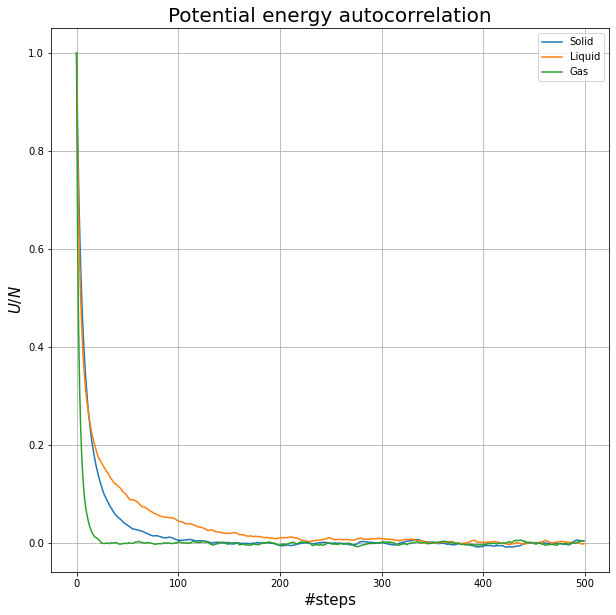

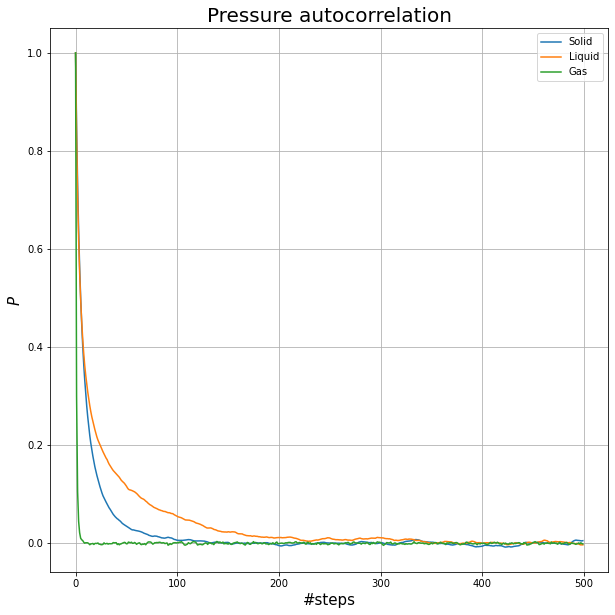

In [4]:
def autocorrelation_correct(tau, array, length):
    if tau > length:
        return 0
    sum = np.zeros(5)
    norm = [length-tau, length-tau, length-tau, length, length]
    
    for i in range(length - tau):
        sum[0] += array[i]
        sum[1] += array[i + tau]
        sum[2] += array[i] * array[i + tau]
    for i in range(length):
        sum[3] += array[i]
        sum[4] += array[i]**2
    for i in range(5):
        sum[i] /= norm[i]
    return (sum[2] - sum[0] * sum[1]) / (sum[4] - sum[3]**2)

def autocorrelation(tau, array, length):
    if tau > length:
        return 0
    sum = np.zeros(5)
    
    for i in range(length - tau):
        sum[0] += array[i]
        sum[1] += array[i + tau]
        sum[2] += array[i] * array[i + tau]
        sum[3] += array[i]**2
        sum[4] += array[i + tau]**2
    for i in range(5):
        sum[i] /= (length - tau)
    return (sum[2] - sum[0] * sum[1]) / np.sqrt((sum[3] - sum[0]**2) * (sum[4] - sum[1]**2))

autocorrelationSize = 500
x = np.arange(autocorrelationSize)
plt.figure(figsize=(10, 10))
plt.title('Potential energy autocorrelation', fontsize=titleSize)
counter = 0
for phase in phases:    
    epot = []
    correlationPotential = np.zeros(autocorrelationSize)
    with open("02/"+str(phase)+'/output.epot.i.0', 'r') as reader:
        for line in reader:
            epot.append(float(line))
    
    for i in range(autocorrelationSize):
        correlationPotential[i] = autocorrelation_correct(i, epot, len(epot))
    plt.plot(x, correlationPotential, label=str(phase))
    counter += 1
    plt.legend()
plt.xlabel('#steps', fontsize=axesLabelSize)
plt.ylabel('$U/N$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10))
plt.title('Pressure autocorrelation', fontsize=titleSize)
for phase in phases:    
    pres = []
    correlationPressure = np.zeros(autocorrelationSize)
    with open("02/"+str(phase)+'/output.pres.i.0', 'r') as reader:
        for line in reader:
            pres.append(float(line))
    
    for i in range(autocorrelationSize):
        correlationPressure[i] = autocorrelation(i, pres, len(pres))
    plt.plot(x, correlationPressure, label=str(phase))
    plt.legend()
plt.xlabel('#steps', fontsize=axesLabelSize)
plt.ylabel('$P$', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

Autocorrelation seems very low with $\tau \approx 200$ steps. From now on, every simulation does 2000 steps per block.

Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks.  
Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

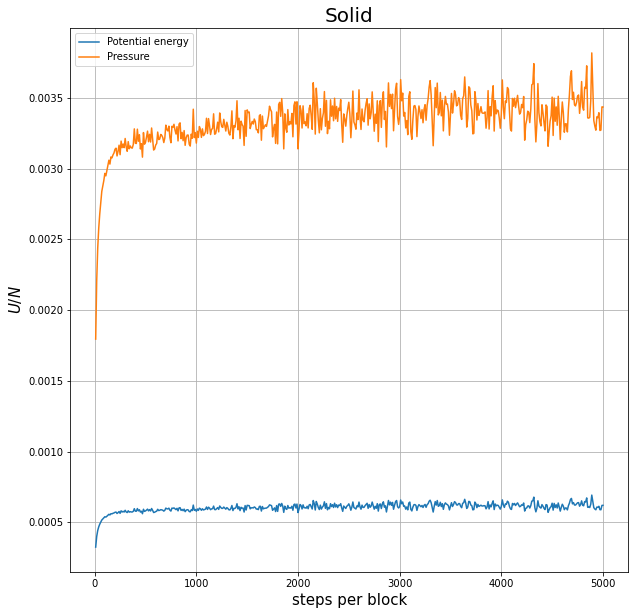

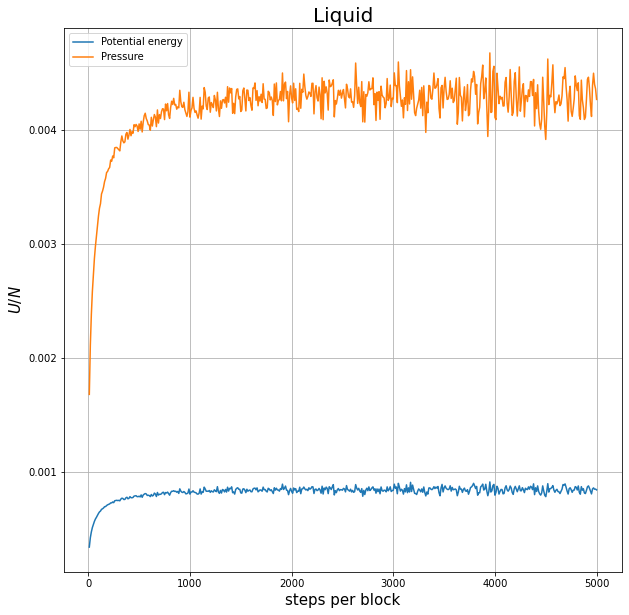

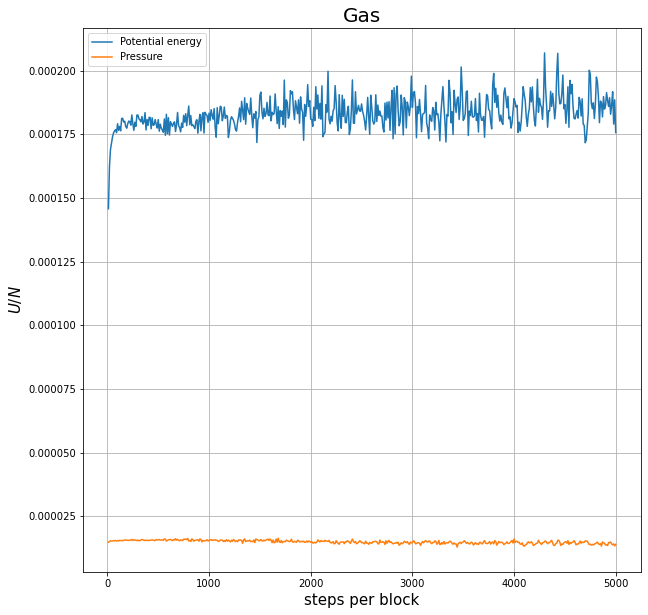

In [11]:
tot = 101
for phase in phases:    
    dataArray = []
    numberOfBlocksArray = []
    for i in range(1,501):
        numberOfBlocksArray.append(i*10)
    tot = len(numberOfBlocksArray)
    
    totalNumbers = 0
    with open("02/"+str(phase)+'/output.epot.i.0', 'r') as reader:
        for line in reader:
            dataArray.append(float(line))
            totalNumbers += 1
    sum_prog = np.zeros(tot)
    su2_prog = np.zeros(tot)
    err_prog = np.zeros(tot)
    for k in range(tot):
        numberOfBlocks = numberOfBlocksArray[k]
        numbersPerBlock = int(totalNumbers/numberOfBlocks)
        numbersPerBlock = numberOfBlocksArray[k]
        numberOfBlocks = int(totalNumbers/numbersPerBlock)
        
        ave = 0
        av2 = 0
        for i in range(numberOfBlocks):
            averageInsideBlock = 0
            for j in range(numbersPerBlock):
                averageInsideBlock += dataArray[j + i * numbersPerBlock]
            averageInsideBlock /= numbersPerBlock
            ave += averageInsideBlock
            av2 += averageInsideBlock * averageInsideBlock
        ave /= numberOfBlocks
        av2 /= numberOfBlocks
        err_prog[k] = np.sqrt((av2 - ave**2) / (numberOfBlocks))
    plt.figure(figsize=(10, 10))
    plt.title(str(phase), fontsize=titleSize)
    plt.plot(numberOfBlocksArray, err_prog, label='Potential energy')
    
    dataArray = np.zeros(totalNumbers)
    totalNumbers = 0
    with open("02/"+str(phase)+'/output.pres.i.0', 'r') as reader:
        for line in reader:
            dataArray[totalNumbers] = float(line)
            totalNumbers += 1
    sum_prog = np.zeros(tot)
    su2_prog = np.zeros(tot)
    err_prog = np.zeros(tot)
    for k in range(tot):
        numbersPerBlock = numberOfBlocksArray[k]
        numberOfBlocks = int(totalNumbers/numbersPerBlock)
        
        ave = 0
        av2 = 0
        for i in range(numberOfBlocks):
            averageInsideBlock = 0
            for j in range(numbersPerBlock):
                averageInsideBlock += dataArray[j + i * numbersPerBlock]
            averageInsideBlock /= numbersPerBlock
            ave += averageInsideBlock
            av2 += averageInsideBlock * averageInsideBlock
        ave /= numberOfBlocks
        av2 /= numberOfBlocks
        err_prog[k] = np.sqrt((av2 - ave**2) / (numberOfBlocks))
    
    plt.plot(numberOfBlocksArray, err_prog, label='Pressure')
    plt.legend()
    plt.xlabel('steps per block', fontsize=axesLabelSize)
    plt.ylabel('$U/N$', fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()

We can see that for a small number of steps per block the uncertainties are underestimated. This is due to the fact that if there is correlation between blocks, the uncertainties are underestimated by the square root of the variance (standard deviation). As the number of steps per block increases, the correlation between blocks decreases and therefore the uncertainties are better estimated.  
What is a good choice for the value of steps per block ($L$) then?  
3000 might be a good value, considering that for the solid phase the autocorrelation decays at a lower rate.

# Exercise 07.2

I included the caluclation of the radial distribution function $g(r)$ in the C++ NVT program.

The raidal distribution function is the ratio between the local density of particles and the total density.
$$
g(r) = \frac{\rho_L(r)}{\rho}
$$

$$
\rho_L(r) = \frac{n}{\frac{4}{3} \pi (r + \frac{\Delta r}{2})^3 - \frac{4}{3} \pi (r - \frac{\Delta r}{2})^3} = 
\frac{3 n}{4 \pi \left[ (r + \frac{\Delta r}{2})^3 - (r - \frac{\Delta r}{2})^3 \right] }
$$

Where $n$ is the number of particles inside the shell and $\Delta r$ is the thickness of the spherical shell.

# Exercise 07.3

I included the caluclation of the radial distribution function $g(r)$ in the C++ NVE program.

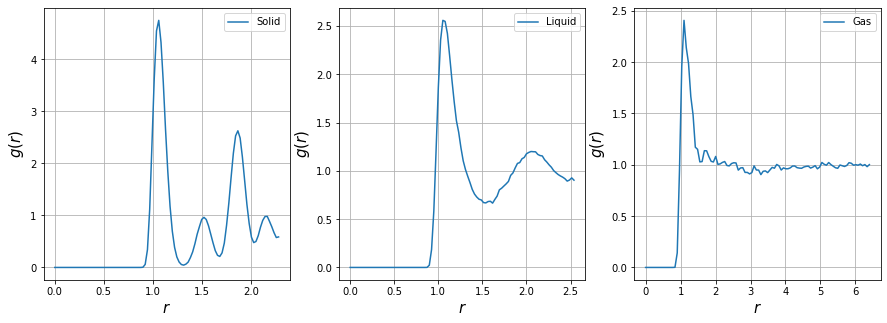

In [125]:
numberOfSimulationsForEquilibrium = 5

def equilibrate_simulation(phase):
    a, b, c = initial_parameters(phase)
    set_input_file(phase, 'NVE', 100, 2000, 1000)
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectoryNVE+"output*"])
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectoryNVE+"ave_*"])
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectoryNVE+"old.0"])
    subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectoryNVE+"config.0"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"config.0_bak "+sourceDirectoryNVE+"config.0"])
    compile_simulation('NVE')
    run_simulation('NVE')
    for i in range(1,numberOfSimulationsForEquilibrium):
        subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectoryNVE+"output*"])
        subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectoryNVE+"ave_*"])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"config.final "+sourceDirectoryNVE+"config.0"])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"old.final "+sourceDirectoryNVE+"old.0"])
        run_simulation('NVE')
        
restart = True
if restart:
    for phase in phases:
        equilibrate_simulation(phase)
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"ave_epot.out 04/"+str(phase)+'/output.epot.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"ave_pres.out 04/"+str(phase)+'/output.pres.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"output.gofr.0 04/"+str(phase)+'/output.gofr.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectoryNVE+"output.gave.0 04/"+str(phase)+'/output.gave.0'])
j = 0
plt.figure(figsize=(15, 5))
plt.title('Radial distribution', fontsize=titleSize)
for phase in phases:    
    gave = []
    x = np.zeros(100)
    a, rho, c = initial_parameters(phase)
    vol = 108/float(rho);
    box = pow(vol,(1.0/3.0))
    i = 0
    with open("04/"+str(phase)+'/output.gave.0', 'r') as reader:
        for line in reader:
            x[i] = float(line.split()[0])
            gave.append(float(line.split()[1]))
            i += 1
    
    x *= box / 200
    plt.subplot(131 + j)
    plt.plot(x, gave, label=str(phase))
    plt.legend()
    plt.xlabel('$r$', fontsize=axesLabelSize)
    plt.ylabel('$g(r)$', fontsize=axesLabelSize)
    plt.grid(True)
    j += 1
plt.show()

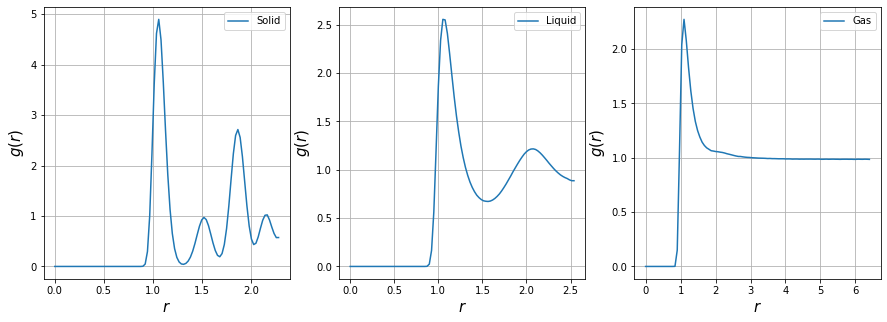

In [108]:
nBlocks = 100
stepsPerBlock = 2000

restart = True
source_directory = source_dir('NVT')

if restart:
    for phase in phases:
        set_input_file(phase, 'NVT', nBlocks, stepsPerBlock, 1000)
        
        subprocess.check_output(["/bin/sh", "-c", "rm -rf "+sourceDirectory+"output*"])
        compile_simulation('NVT')
        run_simulation('NVT')
    
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"output.epot.0 03/"+str(phase)+'/output.epot.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"output.pres.0 03/"+str(phase)+'/output.pres.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"output.gofr.0 03/"+str(phase)+'/output.gofr.0'])
        subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"output.gave.0 03/"+str(phase)+'/output.gave.0'])
j = 0
plt.figure(figsize=(15, 5))
for phase in phases:    
    gave = []
    x = np.zeros(100)
    a, rho, c = initial_parameters(phase)
    vol = 108/float(rho);
    box = pow(vol,(1.0/3.0))
    i = 0
    with open("03/"+str(phase)+'/output.gave.0', 'r') as reader:
        for line in reader:
            x[i] = float(line.split()[0])
            gave.append(float(line.split()[1]))
            i += 1
    
    x *= box / 200
    plt.subplot(131 + j)
    plt.plot(x, gave, label=str(phase))
    plt.legend()
    plt.xlabel('$r$', fontsize=axesLabelSize)
    plt.ylabel('$g(r)$', fontsize=axesLabelSize)
    plt.grid(True)
    j += 1
plt.show()

# Exercise 07.4

By means of your upgraded MC code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in SI units ...  and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

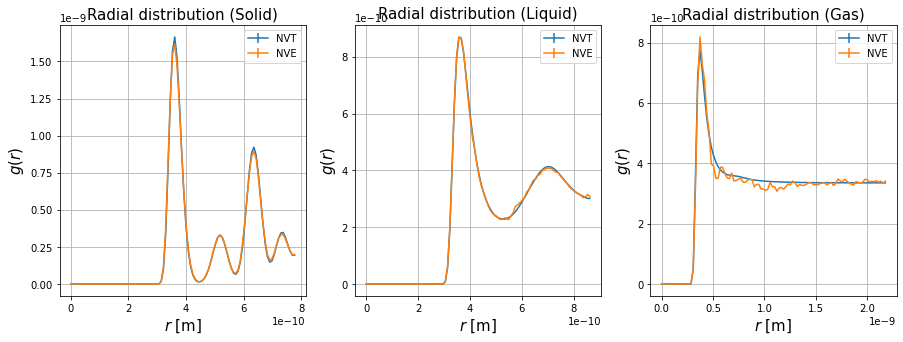

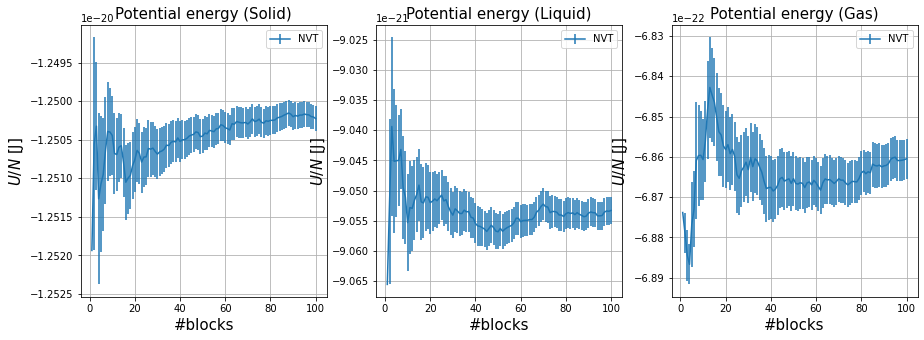

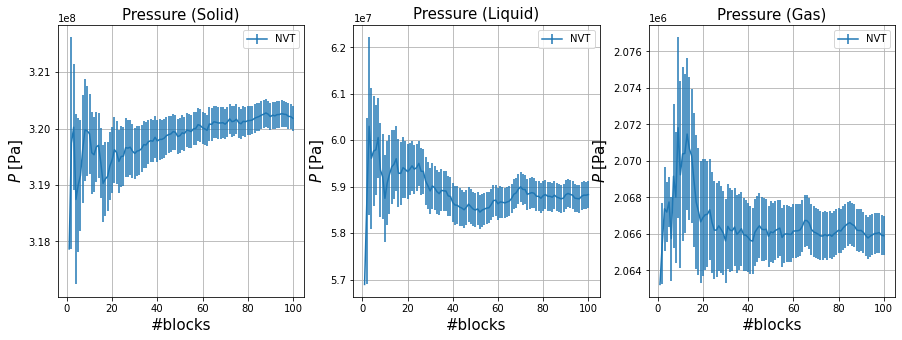

In [142]:
uom = 'SI'
sigma = 0.34*(10**-9)
if uom == 'SI':
    temperatureConverter = 120
    temperatureUom = ' [K]'
    energyConverter = temperatureConverter*scipy.constants.Boltzmann
    energyUom = ' [J]'
    pressureConverter = temperatureConverter*scipy.constants.Boltzmann/(sigma**3)
    pressureUom = ' [Pa]'
    lengthConverter = sigma
    lengthUom = ' [m]'
else:
    temperatureConverter = 1
    temperatureUom = ''
    energyConverter = 1
    energyUom = ''
    pressureConverter = 1
    pressureUom = ''
    lengthConverter = 1
    lengthUom = ''

folders = ['03/', '04/']
program = ['NVT', 'NVE']
arrayLength = [100, 100]
j = 0
plt.figure(figsize=(15, 5))
for phase in phases: 
    a, rho, c = initial_parameters(phase)
    vol = 108/float(rho);
    box = pow(vol,(1.0/3.0))
    plt.subplot(131 + j)
    plt.title('Radial distribution ('+str(phase)+')', fontsize=axesLabelSize)
    for index in range(len(folders)):
        x = np.zeros(arrayLength[index])   
        gave = []
        error = []
        i = 0
        with open(str(folders[index])+str(phase)+'/output.gave.0', 'r') as reader:
            for line in reader:
                x[i] = float(line.split()[0])
                gave.append(float(line.split()[1]) * lengthConverter)
                error.append(float(line.split()[2]) * energyConverter)
                i += 1
        x *= box / (2*i) * lengthConverter
        plt.errorbar(x, gave, yerr=error, label=str(program[index]))
    plt.legend()
    plt.xlabel('$r$'+lengthUom, fontsize=axesLabelSize)
    plt.ylabel('$g(r)$'+lengthUom, fontsize=axesLabelSize)
    plt.grid(True)
    j += 1
plt.show()

j = 0
plt.figure(figsize=(15, 5))
for phase in phases:
    plt.subplot(131 + j)
    plt.title('Potential energy ('+str(phase)+')', fontsize=axesLabelSize)
    epot = []
    error = []
    x = np.zeros(arrayLength[index]) 
    i = 0
    with open('03/'+str(phase)+'/output.epot.0', 'r') as reader:
        for line in reader:
            x[i] = (int(line.split()[0]))
            epot.append(float(line.split()[2]) * energyConverter)
            error.append(float(line.split()[3]) * energyConverter)
            i += 1
    plt.errorbar(x, epot, yerr=error, label='NVT')
    plt.legend()
    plt.xlabel('#blocks', fontsize=axesLabelSize)
    plt.ylabel('$U/N$'+energyUom, fontsize=axesLabelSize)
    plt.grid(True)
    j += 1
plt.show()

j = 0
plt.figure(figsize=(15, 5))
for phase in phases:
    plt.subplot(131 + j)
    plt.title('Pressure ('+str(phase)+')', fontsize=axesLabelSize)
    i = 0
    x = np.zeros(arrayLength[index]) 
    epot = []
    error = []
    with open('03/'+str(phase)+'/output.pres.0', 'r') as reader:
        for line in reader:
            x[i] = float(line.split()[0])
            epot.append(float(line.split()[2]) * pressureConverter)
            error.append(float(line.split()[3]) * pressureConverter)
            i += 1
    
    plt.errorbar(x, epot, yerr=error, label='NVT')
    plt.legend()
    plt.xlabel('#blocks', fontsize=axesLabelSize)
    plt.ylabel('$P$'+pressureUom, fontsize=axesLabelSize)
    plt.grid(True)
    j += 1
plt.show()